In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from geopy.distance import geodesic as geopy_geodesic

In [2]:
def mean_geodetic_distance(y_true_lat, y_true_long, y_pred_lat, y_pred_long):
    distances = [
        geopy_geodesic((true_lat, true_long), (pred_lat, pred_long)).km
        for true_lat, true_long, pred_lat, pred_long in zip(
            y_true_lat, y_true_long, y_pred_lat, y_pred_long
        )
    ]
    return np.mean(distances)

## Load data

In [3]:
train_df = pd.read_csv("../data/ais_train.csv", sep="|")
train_df["time"] = pd.to_datetime(train_df["time"])
test_df = pd.read_csv("../data/ais_test.csv")
test_df["time"] = pd.to_datetime(test_df["time"])

# ports_df = pd.read_csv("../data/ports.csv", sep="|")
# schedules_df = pd.read_csv("../data/schedules_to_may_2024.csv", sep="|")
vessels_df = pd.read_csv("../data/vessels.csv", sep="|")
# train_df["etaRaw"] = pd.to_datetime(train_df["etaRaw"], format="%Y/%m/%d %H:%M")
train_df.tail()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
1522060,2024-05-07 23:59:07,359.1,13.4,0,1,0,05-08 05:00,52.19131,-5.82223,clh6aqawa0002gh0zypfa5dut,634c4de270937fc01c3a7417
1522061,2024-05-07 23:59:08,12.3,17.1,0,13,0,05-10 03:00,38.96142,-12.00502,61e9f3aeb937134a3c4bfe43,634c4de270937fc01c3a76a1
1522062,2024-05-07 23:59:08,269.8,14.9,-1,270,0,05-15 23:00,49.71372,-5.22042,61e9f43db937134a3c4c0169,634c4de270937fc01c3a787b
1522063,2024-05-07 23:59:08,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,61e9f469b937134a3c4c029b,61d3781293c6feb83e5eb73b
1522064,2024-05-07 23:59:08,336.0,14.3,5,337,0,05-07 23:00,38.98635,-75.13275,62080cff66fc0a8e43c6123a,61d38528b7b7526e1adf3e6f


In [4]:
ais_cols = ["cog", "sog", "rot", "heading", "latitude", "longitude"]
test_start = "2024-05-08 00:00:00"

## Preprocessing and feature engineering

#### Drop vessels with very few rows

In [5]:
train_df = train_df[
    ~train_df["vesselId"].isin(["61e9f3adb937134a3c4bfe37", "61e9f3cbb937134a3c4bff09"])
]

#### Remove duplicated vessel

In [6]:
duplicated_vessel = "clh6aqawa0001gh0zmijpuho1"
duplicated_from = "63d27587e3fba838ce820405"
train_df = train_df[train_df["vesselId"] != duplicated_vessel]
# test_df.loc[test_df["vesselId"] == duplicated_vessel, "vesselId"] = duplicated_from

#### Set default/missing values to nan

In [7]:
train_df.loc[train_df["cog"] >= 360, "cog"] = np.nan
train_df.loc[train_df["sog"] >= 102.3, "sog"] = np.nan
train_df.loc[abs(train_df["rot"]) >= 128, "rot"] = np.nan
train_df.loc[train_df["heading"] > 360, "heading"] = np.nan
train_df.loc[train_df["navstat"] >= 9, "navstat"] = np.nan

#### Aggregate vessel stats and cluster

In [8]:
# Calculate statistics for each vessel
vessel_stats = (
    train_df.groupby("vesselId")
    .agg(
        mean_latitude=("latitude", "mean"),
        mean_longitude=("longitude", "mean"),
        mean_speed=("sog", "mean"),
        median_speed=("sog", "median"),
        std_speed=("sog", "std"),
        count_entries=("vesselId", "size"),
        pct_navstat_0=("navstat", lambda x: ((x == 0) | (x == 8)).mean() * 100),
        pct_navstat_1=("navstat", lambda x: (x == 1).mean() * 100),
        pct_navstat_5=("navstat", lambda x: (x == 5).mean() * 100),
    )
    .reset_index()
)
vessel_stats_cols = [col for col in vessel_stats.columns.to_list() if col != "vesselId"]
vessels_df = vessels_df.merge(vessel_stats, on="vesselId", how="left")

In [9]:
train_df["scaling_factor"] = np.nan
train_df["ID"] = -1
full_df = pd.concat([train_df, test_df]).sort_values(["vesselId", "time"]).reset_index()

#### Time diff

In [10]:
full_df["time_diff"] = full_df.groupby("vesselId")["time"].diff().astype(int) // 10**9

# Assume time diff before first msg was 20 min
full_df.loc[full_df["time_diff"] < 0, "time_diff"] = 60 * 20

# full_df = full_df[full_df["time_diff"] >= 60].reset_index(drop=True)

In [11]:
train_mask = full_df["ID"] == -1
full_df["etaRaw"] = pd.to_datetime("2024-" + full_df["etaRaw"], errors="coerce")

#### Add prev position, distance, fwd_azimuth, computed sog

In [12]:
from pyproj import Geod

In [13]:
full_df[["prev_lat", "prev_lng"]] = full_df.groupby("vesselId")[
    ["latitude", "longitude"]
].shift()

In [14]:
geodesic = Geod(ellps="WGS84")
fwd_azimuth, back_azimuth, distance = geodesic.inv(
    full_df["prev_lng"],
    full_df["prev_lat"],
    full_df["longitude"],
    full_df["latitude"],
)

full_df["distance"] = distance / (1000 * 1.852)
full_df["fwd_azimuth"] = fwd_azimuth
full_df["dx"] = (full_df.groupby("vesselId")["longitude"].diff() + 180) % 360 - 180
full_df["dy"] = full_df.groupby("vesselId")["latitude"].diff()

In [15]:
full_df["computed_sog"] = full_df["distance"] / (full_df["time_diff"] / 3600)

#### Merge vessels df

In [16]:
vessel_cols = [
    "shippingLineId",
    "vesselId",
    "CEU",
    "DWT",
    "GT",
    "breadth",
    "length",
    "yearBuilt",
]

full_df = full_df.merge(
    vessels_df[vessel_cols + vessel_stats_cols],
    on="vesselId",
    how="left",
)

#### Merge ports df (calculate distance to closest port)

In [17]:
def df_to_gdf(
    df: pd.DataFrame, longitude_col="longitude", latitude_col="latitude"
) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[longitude_col], df[latitude_col]),
        crs="EPSG:4326",
    )

In [18]:
closest_ports = pd.read_csv("../data/ports.csv", sep="|").rename(
    {
        "portId": "closest_port",
        "latitude": "latitude_port",
        "longitude": "longitude_port",
    },
    axis=1,
)

In [19]:
orig_cols = full_df.columns.to_list()
distance_col = "dist_to_port"

ports_gdf = df_to_gdf(
    closest_ports, longitude_col="longitude_port", latitude_col="latitude_port"
).to_crs(epsg="3857")

full_gdf = df_to_gdf(
    full_df, longitude_col="longitude", latitude_col="latitude"
).to_crs(epsg="3857")

full_gdf = full_gdf.sjoin_nearest(ports_gdf, how="left", distance_col=distance_col)
full_df[[distance_col, "closest_port", "latitude_port", "longitude_port"]] = full_gdf[
    [distance_col, "closest_port", "latitude_port", "longitude_port"]
]

closest_port_cols = [distance_col, "latitude_port", "longitude_port"]

#### Distance to land

In [20]:
land_world = gpd.read_file("../data/land_and_ocean/ne_110m_land.zip")
land_world = land_world.to_crs(epsg=3857)

In [21]:
orig_cols = full_df.columns.to_list()
df_gdf = df_to_gdf(full_df).to_crs(epsg="3857")

df_with_land = df_gdf.sjoin_nearest(
    land_world, how="left", distance_col="distance_to_land"
)

full_df = pd.DataFrame(df_with_land)[orig_cols + ["distance_to_land"]]

#### Add temporal features

In [22]:
def add_temporal_cols_discrete(df: pd.DataFrame, time_col: str) -> pd.DataFrame:
    df[f"{time_col}_minute"] = df[time_col].dt.minute
    df[f"{time_col}_hour"] = df[time_col].dt.hour
    df[f"{time_col}_day_of_week"] = df[time_col].dt.dayofweek
    df[f"{time_col}_day_of_month"] = df[time_col].dt.day
    df[f"{time_col}_month"] = df[time_col].dt.month
    df[f"{time_col}_day_of_year"] = df[time_col].dt.dayofyear
    cols = [
        f"{time_col}_minute",
        f"{time_col}_hour",
        f"{time_col}_day_of_week",
        f"{time_col}_day_of_month",
        f"{time_col}_month",
        f"{time_col}_day_of_year",
    ]
    return df, cols

In [23]:
def add_temporal_cols_continuous(df: pd.DataFrame) -> pd.DataFrame:
    day_s = 24 * 60 * 60
    year_s = (366) * day_s
    month_s = year_s // 12
    timestamp_s = (df["time"] - pd.Timestamp("2024-01-01")) // pd.Timedelta("1s")

    df["time_day_sin"] = np.sin(timestamp_s * (2 * np.pi / day_s))
    df["time_day_cos"] = np.cos(timestamp_s * (2 * np.pi / day_s))
    df["time_year_sin"] = np.sin(timestamp_s * (2 * np.pi / year_s))
    df["time_year_cos"] = np.cos(timestamp_s * (2 * np.pi / year_s))
    df["time_month_sin"] = np.sin(timestamp_s * (2 * np.pi / month_s))
    df["time_month_cos"] = np.cos(timestamp_s * (2 * np.pi / month_s))
    cols = [
        f"time_day_sin",
        f"time_day_cos",
        f"time_year_sin",
        f"time_year_cos",
        f"time_month_sin",
        f"time_month_cos",
    ]
    return df, cols

In [24]:
full_df, time_cols = add_temporal_cols_discrete(full_df, "time")
full_df, eta_cols = add_temporal_cols_discrete(full_df, "etaRaw")

#### Circular features

In [25]:
def add_circular_features(df, lat_col, long_col, azimuth_col):
    # Convert degrees to radians
    df["lat_rad"] = np.deg2rad(df[lat_col])
    df["lon_rad"] = np.deg2rad(df[long_col])
    df["azimuth_rad"] = np.deg2rad(df[azimuth_col])

    # Sine and Cosine transformations
    df["sin_lat"] = np.sin(df["lat_rad"])
    df["cos_lat"] = np.cos(df["lat_rad"])
    df["sin_lon"] = np.sin(df["lon_rad"])
    df["cos_lon"] = np.cos(df["lon_rad"])
    df["sin_azimuth"] = np.sin(df["azimuth_rad"])
    df["cos_azimuth"] = np.cos(df["azimuth_rad"])
    cols = ["sin_lat", "cos_lat", "sin_lon", "cos_lon", "cos_azimuth", "sin_azimuth"]

    return df, cols


full_df, circular_cols = add_circular_features(
    full_df, "latitude", "longitude", "fwd_azimuth"
)

#### Categorical encoding

In [26]:
from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder

In [27]:
# Counts of ports might be useful for estimating the size / popularity of the port
count_ports_encoder = CountEncoder(handle_missing="value", handle_unknown=-1)
full_df["port_count"] = count_ports_encoder.fit_transform(
    full_df.loc[full_df["ID"] == -1, "closest_port"].values
)
full_df.loc[~full_df["closest_port"].isna(), "closest_port_count"] = (
    count_ports_encoder.transform(
        full_df.loc[~full_df["closest_port"].isna(), "closest_port"].values
    ).values
)

port_cols = ["port_count", "closest_port_count"]

In [28]:
shipping_line_encoder = CountEncoder()
shipping_line_encoder.fit(full_df["shippingLineId"].values)
full_df["shipping_line_count"] = shipping_line_encoder.transform(
    full_df["shippingLineId"].values
)

In [29]:
one_hot_cols = [
    "navstat_1or5",
    "navstat_0or8",
    "navstat_2.0",
    "navstat_nan",
]

one_hot = OneHotEncoder(cols=["navstat"], handle_missing="value", use_cat_names=True)
encoded = one_hot.fit_transform(full_df[["navstat"]])
encoded["navstat_0or8"] = np.logical_or(
    encoded["navstat_0.0"], encoded["navstat_8.0"]
).astype(int)
encoded["navstat_1or5"] = np.logical_or(
    encoded["navstat_1.0"], encoded["navstat_5.0"]
).astype(int)

full_df[one_hot_cols] = encoded[one_hot_cols]

#### Lag/rolling features

In [30]:
lag_cols = [
    "prev_lat",
    "prev_lng",
    "distance",
    "fwd_azimuth",
    "time_diff",
    "dist_to_port",
]

rolling_cols = ["distance"]

lags = [1, 2, 3]
windows = [4, 12, 24]
for col in lag_cols:
    # Add lags
    for lag in lags:
        full_df[f"{col}_lag{lag}"] = full_df.groupby("vesselId")[col].shift(lag)

for col in rolling_cols:
    for window in windows:
        full_df[f"{col}_rolling_sum_{window}"] = (
            full_df.groupby("vesselId")[col]
            .rolling(window=window, min_periods=1)
            .sum()
            .reset_index(0, drop=True)
        )

lag_cols = [
    f"{col}_{transform}" for col in lag_cols for transform in [f"lag{i}" for i in lags]
]

rolling_cols = [
    f"{col}_{transform}"
    for col in rolling_cols
    for transform in [f"rolling_sum_{w}" for w in windows]
]

#### Stationary time, and non stationary distance

In [31]:
def cumulative_stationary_time(group):
    cumulative_time = 0
    cumulative_times = []

    for stationary, time in zip(group["is_stationary"], group["time_diff"]):
        if stationary:
            cumulative_time += time
        else:
            cumulative_time = 0  # Reset cumulative time if not stationary
        cumulative_times.append(cumulative_time)

    return pd.Series(cumulative_times, index=group.index)


def cumulative_distance(group):
    cumulative_distance = 0
    cumulative_distances = []

    for stationary, distance in zip(group["is_stationary"], group["distance"]):
        if not stationary:
            cumulative_distance += distance
        else:
            cumulative_distance = 0  # Reset cumulative distance if stationary
        cumulative_distances.append(cumulative_distance)

    return pd.Series(cumulative_distances, index=group.index)

In [32]:
full_df["is_stationary"] = full_df["distance_rolling_sum_4"] < 0.5
full_df["cumulative_stationary_time"] = full_df.groupby(
    "vesselId", group_keys=False
).apply(cumulative_stationary_time)

full_df["cumulative_distance"] = full_df.groupby("vesselId", group_keys=False).apply(
    cumulative_distance
)

stationary_cols = ["is_stationary", "cumulative_stationary_time", "cumulative_distance"]

/tmp/ipykernel_6598/4208599759.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(cumulative_stationary_time)
/tmp/ipykernel_6598/4208599759.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full_df["cumulative_distance"] = full_df.groupby("vesselId", group_keys=False).apply(


#### Finalize dataset

In [33]:
features = (
    ais_cols
    + [
        "time_diff",
        "prev_lat",
        "prev_lng",
        "dx",
        "dy",
        "distance",
        "fwd_azimuth",
        "computed_sog",
        "distance_to_land",
        "shipping_line_count",
        "cumulative_time_diff",
    ]
    + vessel_cols
    + vessel_stats_cols
    + closest_port_cols
    + port_cols
    + time_cols
    + eta_cols
    + circular_cols
    + one_hot_cols
    + lag_cols
    + rolling_cols
    + stationary_cols
)

In [34]:
train_mask = full_df["ID"] == -1
# val_df = full_df[(full_df["time"] > val_cutoff) & (full_df["time"] < test_start)]
train_df = full_df[full_df["time"] < test_start]
test_df = full_df[full_df["time"] >= test_start]
# test_df = (
#     pd.concat([train_df.groupby("vesselId").tail(24), test_df])
#     .sort_values(["vesselId", "time"])
#     .reset_index()
# )

#### Create five day prediction blocks

In [35]:
from tqdm import tqdm

In [36]:
def create_target_blocks(df: pd.DataFrame, stride: int, horizon=5):
    min_time = df["time"].min()
    max_time = df["time"].max().ceil("D")
    start_times = []
    results = []

    while max_time > min_time:
        start_times.append(max_time)
        max_time -= pd.Timedelta(f"{stride}D")

    start_times = start_times[::-1]  # reverse

    for i in range(len(start_times) - 1):
        start_time = start_times[i]
        end_time = start_time + pd.Timedelta(f"{horizon}D")

        if end_time > df["time"].max() + pd.Timedelta("1D"):
            break

        block = df[(df["time"] >= start_time) & (df["time"] < end_time)]
        prev_vessel_positions = df[df["time"] < start_time].groupby("vesselId").tail(1)

        with tqdm(
            total=len(block["vesselId"].unique()),
            desc=f"Block {start_time.strftime('%Y-%m-%d')} to {end_time.strftime('%Y-%m-%d')}",
        ) as progress_bar:
            for vesselId in block["vesselId"].unique():
                prev_row = prev_vessel_positions[
                    prev_vessel_positions["vesselId"] == vesselId
                ].copy()

                if prev_row.empty:
                    progress_bar.update()
                    continue

                vessel_rows = block[block["vesselId"] == vesselId][
                    ["latitude", "longitude", "time_diff"]
                ].copy()
                cumulative_time_diff = vessel_rows["time_diff"].cumsum()
                vessel_rows["cumulative_time_diff"] = cumulative_time_diff

                targets = pd.concat([prev_row] * len(vessel_rows), ignore_index=True)
                targets["cumulative_time_diff"] = vessel_rows[
                    "cumulative_time_diff"
                ].values
                targets["latitude_target"] = vessel_rows["latitude"].values
                targets["longitude_target"] = vessel_rows["longitude"].values
                results.append(targets)
                progress_bar.update()

    return pd.concat(results)

: 

In [37]:
blocks = create_target_blocks(train_df, 5)

Block 2024-04-13 to 2024-04-18: 100%|██████████| 530/530 [00:15<00:00, 33.27it/s]


## Training

In [35]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import TransformedTargetRegressor

#### Models

In [36]:
model_lat = TransformedTargetRegressor(
    regressor=xgb.XGBRegressor(max_depth=12, n_estimators=100, random_state=42),
    func=np.deg2rad,
    inverse_func=np.rad2deg,
)

model_lng = TransformedTargetRegressor(
    regressor=xgb.XGBRegressor(max_depth=12, n_estimators=100, random_state=42),
    func=np.deg2rad,
    inverse_func=np.rad2deg,
)

model_dist = TransformedTargetRegressor(
    regressor=xgb.XGBRegressor(max_depth=12, n_estimators=100, random_state=42),
    func=lambda x: np.log(x + 0.1),
    inverse_func=lambda x: np.exp(x) - 0.1,
)

#### Training

In [38]:
model_lat.fit(train_df[~stationary][features], train_df[~stationary]["latitude"])
model_lng.fit(train_df[~stationary][features], train_df[~stationary]["longitude"])
model_dist.fit(train_df[features], train_df["distance"])

TransformedTargetRegressor(func=<function <lambda> at 0x7fdd75bb5990>,
                           inverse_func=<function <lambda> at 0x7fdd75bb5a20>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  g...ne, grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=12, max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=100, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=42, ...))

#### Make predictions autoregressively

In [39]:
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

In [40]:
def find_closest_port_for_row(df_row, longitude_col, latitude_col):
    row_gdf = df_to_gdf(
        df_row, longitude_col=longitude_col, latitude_col=latitude_col
    ).to_crs(epsg="3857")

    row_with_nearest_port = row_gdf.sjoin_nearest(
        ports_gdf, how="left", distance_col="dist_to_port"
    )

    # Extract the closest port info
    closest_port = row_with_nearest_port["closest_port"].values[0]
    dist_to_port = row_with_nearest_port["dist_to_port"].values[0]
    latitude_port = row_with_nearest_port["latitude_port"].values[0]
    longitude_port = row_with_nearest_port["longitude_port"].values[0]

    return closest_port, dist_to_port, latitude_port, longitude_port

In [43]:
test_df

,level_0,index,time,cog,sog,rot,heading,navstat,etaRaw,latitude,...,prev_distance_rolling_sum_24,lat_rad,lon_rad,azimuth_rad,sin_lat,cos_lat,sin_lon,cos_lon,sin_azimuth,cos_azimuth
0,375,1480819,2024-05-04 13:31:37,149.5,16.7,0.0,150.0,0.0,2024-05-04 23:59:00,38.77871,...,183.779288,0.678010,0.077388,2.551119,0.627244,0.778823,0.077311,0.997007,0.556755,-0.830677
1,376,1481022,2024-05-04 13:56:24,146.5,17.1,0.0,148.0,0.0,2024-05-04 23:59:00,38.68037,...,188.526252,0.676816,0.078280,2.612070,0.626314,0.779571,0.078201,0.996938,0.505122,-0.863048
2,377,1481199,2024-05-04 14:18:00,148.0,17.3,1.0,149.0,0.0,2024-05-04 23:59:00,38.59375,...,195.494231,0.675100,0.079664,2.578022,0.624975,0.780645,0.079580,0.996829,0.534208,-0.845353
3,378,1482177,2024-05-04 16:15:36,148.4,17.2,0.0,146.0,0.0,2024-05-04 23:59:00,38.10319,...,418.864668,0.666463,0.085966,2.528942,0.618209,0.786013,0.085861,0.996307,0.575038,-0.818127
4,379,1482279,2024-05-04 16:33:24,148.2,16.9,-1.0,146.0,0.0,2024-05-04 23:59:00,38.03150,...,424.679060,0.665026,0.087102,2.583005,0.617080,0.786901,0.086992,0.996209,0.529989,-0.848005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68174,1566024,51161,2024-05-12 22:37:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68175,1566025,51302,2024-05-12 22:58:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68176,1566026,51444,2024-05-12 23:18:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68177,1566027,51595,2024-05-12 23:39:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
def time_series_prediction(test_df: pd.DataFrame):
    lng_pred = []
    lat_pred = []
    total_steps = test_df.shape[0]

    with tqdm(total=total_steps) as progress_bar:
        for vesselId in test_df["vesselId"].unique():
            vessel_rows = test_df[test_df["vesselId"] == vesselId].copy()

            steps = vessel_rows.shape[0]
            vessel_rows["step"] = np.arange(steps)

            for i in range(steps):
                row = vessel_rows.loc[vessel_rows["step"] == i]
                if row["time"].item() < pd.Timestamp(test_start):
                    progress_bar.update()
                    continue

                distance_pred = model_dist.predict(row[features]).item()

                if (distance_pred < 0.1 and row["time_diff"].item() > 60) and (
                    row["dist_to_port"].item() < 10000 and row["prev_sog"].item() < 0.1
                ):
                    latitude = row["prev_lat"].item()
                    longitude = row["prev_lng"].item()
                    distance = distance_pred
                else:
                    latitude = model_lat.predict(row[features]).item()
                    longitude = model_lng.predict(row[features]).item()
                    fwd_azimuth, back_azimuth, distance_calc = geodesic.inv(
                        row["prev_lng"].item(),
                        row["prev_lat"].item(),
                        longitude,
                        latitude,
                    )
                    distance = (distance_calc / (1.852 * 1000) + distance_pred) / 2

                lng_pred.append(longitude)
                lat_pred.append(latitude)

                sog = distance / (row["time_diff"].item() / 3600)
                closest_port, dist_to_port, latitude_port, longitude_port = (
                    find_closest_port_for_row(
                        row[["prev_lat", "prev_lng"]],
                        latitude_col="prev_lat",
                        longitude_col="prev_lng",
                    )
                )
                closest_port_count = count_ports_encoder.transform(
                    [closest_port]
                ).values.item()

                if i < steps - 1:
                    vessel_rows.loc[
                        vessel_rows["step"] == i + 1,
                        [
                            "prev_distance",
                            "prev_fwd_azimuth",
                            "prev_lat",
                            "prev_lng",
                            "cos_lat",
                            "sin_lat",
                            "cos_lon",
                            "sin_lon",
                            "cos_azimuth",
                            "sin_azimuth",
                            "prev_sog",
                            "closest_port_count",
                            "dist_to_port",
                            "latitude_port",
                            "longitude_port",
                        ],
                    ] = [
                        distance,
                        fwd_azimuth,
                        latitude,
                        longitude,
                        np.cos(np.deg2rad(latitude)),
                        np.sin(np.deg2rad(latitude)),
                        np.cos(np.deg2rad(longitude)),
                        np.sin(np.deg2rad(longitude)),
                        np.cos(np.deg2rad(fwd_azimuth)),
                        np.sin(np.deg2rad(fwd_azimuth)),
                        sog,
                        closest_port_count,
                        dist_to_port.item(),
                        latitude_port.item(),
                        longitude_port.item(),
                    ]

                    for col in [col for col in lag_cols if col != "time_diff"]:
                        vessel_rows.loc[vessel_rows["step"] == i + 1, f"{col}_lag1"] = (
                            vessel_rows.loc[vessel_rows["step"] == i, col].item()
                        )
                        for lag in range(2, 5):
                            vessel_rows.loc[
                                vessel_rows["step"] == i + 1, f"{col}_lag{lag}"
                            ] = vessel_rows.loc[
                                vessel_rows["step"] == i, f"{col}_lag{lag-1}"
                            ].item()

                        for window in [4, 12, 24]:
                            vessel_rows.loc[
                                vessel_rows["step"] == i + 1,
                                f"{col}_rolling_mean_{window}",
                            ] = (
                                vessel_rows.loc[vessel_rows["step"] <= i + 1, col]
                                .tail(window)
                                .mean()
                            )

                    for window in [4, 12, 24]:
                        vessel_rows.loc[
                            vessel_rows["step"] == i + 1,
                            f"prev_distance_rolling_sum_{window}",
                        ] = (
                            vessel_rows.loc[
                                vessel_rows["step"] <= i + 1, "prev_distance"
                            ]
                            .tail(window)
                            .sum()
                        )

                progress_bar.update()

    return lat_pred, lng_pred


lat_pred, lng_pred = time_series_prediction(test_df)

100%|██████████| 68179/68179 [1:00:47<00:00, 18.69it/s] 


In [47]:
test_df = test_df[test_df["time"] > test_start]
test_df["latitude_predicted"] = lat_pred
test_df["longitude_predicted"] = lng_pred
test_df.loc[
    test_df["vesselId"] == duplicated_vessel,
    ["longitude_predicted", "latitude_predicted"],
] = test_df[test_df["vesselId"] == duplicated_from][
    ["longitude_predicted", "latitude_predicted"]
].values

In [48]:
test_df[["ID", "longitude_predicted", "latitude_predicted"]].sort_values(
    "ID"
).reset_index(drop=True).to_csv("submission_6.csv", index=False)

In [49]:
import plotly.express as px
import plotly.graph_objects as go

In [50]:
def visualize_vessel_movements(
    df, lng_col="longitude_predicted", lat_col="latitude_predicted"
):
    """
    Visualize vessel movements on a map with lines and markers for each data point.

    Parameters:
    - df (pandas.DataFrame): A DataFrame with columns ['time', 'latitude', 'longitude', 'vesselId'].

    Returns:
    - A Plotly interactive figure.
    """
    # Ensure 'time' is in datetime format for better tooltip handling
    df["time"] = pd.to_datetime(df["time"])

    # Sorting the DataFrame by time to ensure lines are drawn correctly
    df = df.sort_values(by=["vesselId", "time"])

    # Define a color palette
    color_map = px.colors.qualitative.Plotly

    # Mapping each vessel ID to a color
    unique_vessels = df["vesselId"].unique()
    colors = {
        vessel_id: color_map[i % len(color_map)]
        for i, vessel_id in enumerate(unique_vessels)
    }

    # Create the base map with lines
    fig = px.line_geo(
        df,
        lat=lat_col,
        lon=lng_col,
        color="vesselId",
        color_discrete_map=colors,
        hover_name="vesselId",
        hover_data={"time": True, lat_col: ":.3f", lng_col: ":.3f"},
        projection="natural earth",
        title="Vessel Movements Over Time",
    )

    # Add markers for each data point
    for vessel_id in unique_vessels:
        vessel_data = df[df["vesselId"] == vessel_id]
        fig.add_trace(
            go.Scattergeo(
                lon=vessel_data[lng_col],
                lat=vessel_data[lat_col],
                mode="markers",
                marker=dict(
                    size=8,
                    color=colors[vessel_id],
                    opacity=0.8,
                    line=dict(width=1, color="DarkSlateGrey"),
                ),
                name=f"Markers for {vessel_id}",
                hoverinfo="text",
                text=vessel_data.apply(
                    lambda row: f'ID: {vessel_id}<br>Time: {row["time"]}<br>Lat: {row[lat_col]:.3f}<br>Lon: {row[lng_col]:.3f}',
                    axis=1,
                ),
            )
        )

    # Enhancing map and layout details
    fig.update_geos(
        fitbounds="locations", showcountries=True, countrycolor="RebeccaPurple"
    )
    fig.update_layout(
        margin={"r": 0, "t": 30, "l": 0, "b": 0},
        coloraxis_colorbar=dict(title="Vessel ID"),
        title_font_size=20,
    )

    return fig

In [85]:
vessel = np.random.choice(test_df["vesselId"].unique())

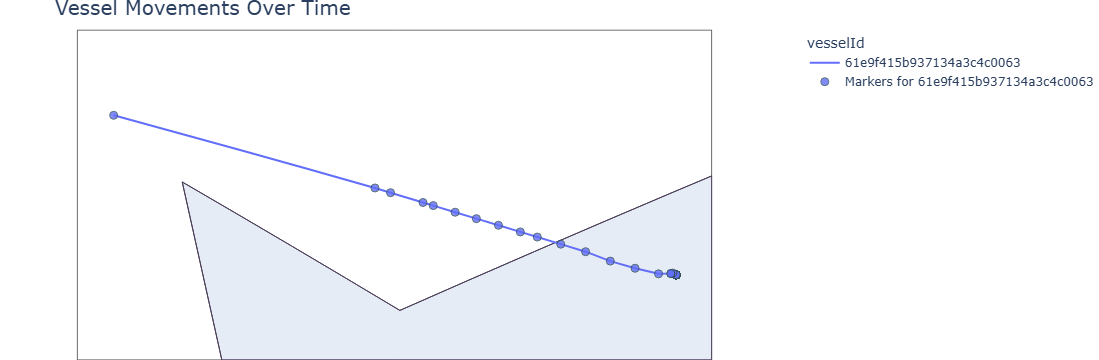

In [86]:
fig = visualize_vessel_movements(
    train_df[
        (train_df["vesselId"] == vessel)
        & (train_df["time"] > train_df["time"].max() - pd.Timedelta("5d"))
    ],
    lat_col="latitude",
    lng_col="longitude",
)
fig.show()

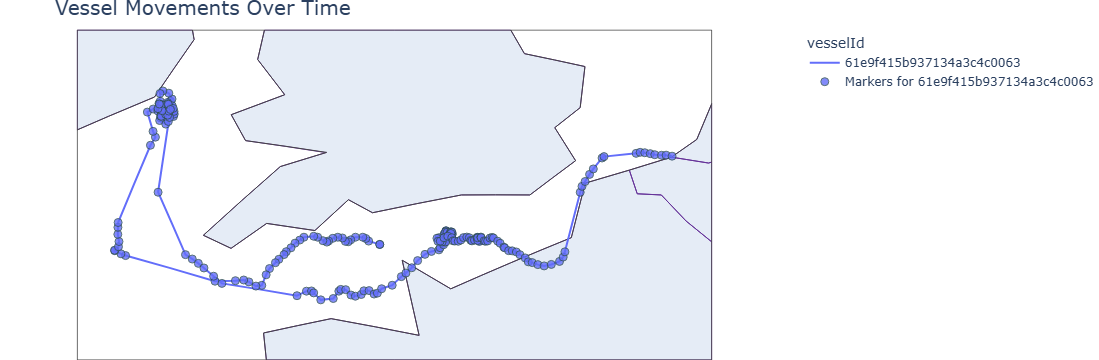

In [87]:
fig = visualize_vessel_movements(test_df[test_df["vesselId"] == vessel])
fig.show()